(576, 17)
Epoch 0/1500 - Training Loss: 557946.6562315885


<ipython-input-6-311d647cf1f7>:62: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 100/1500 - Training Loss: 121461.71488270453
Epoch 200/1500 - Training Loss: 172859.41790959134
Epoch 300/1500 - Training Loss: 165551.4860148828
Epoch 400/1500 - Training Loss: 172619.4693937273
Epoch 500/1500 - Training Loss: 175331.36587751363
Epoch 600/1500 - Training Loss: 175407.0860451303
Epoch 700/1500 - Training Loss: 175203.47421900064
Epoch 800/1500 - Training Loss: 175194.53849854175
Epoch 900/1500 - Training Loss: 175123.3310984696
Epoch 1000/1500 - Training Loss: 175895.34651000577
Epoch 1100/1500 - Training Loss: 175447.59432366287
Epoch 1200/1500 - Training Loss: 175013.0049980142
Epoch 1300/1500 - Training Loss: 174598.83241285422
Epoch 1400/1500 - Training Loss: 174818.69513303394
Final Training Loss: 174817.89562236177
Train RMSE: 5.472226996629958
Test RMSE: 4.562030210281221


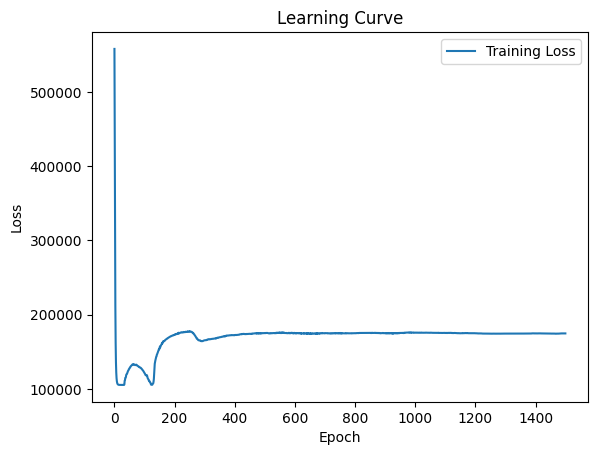

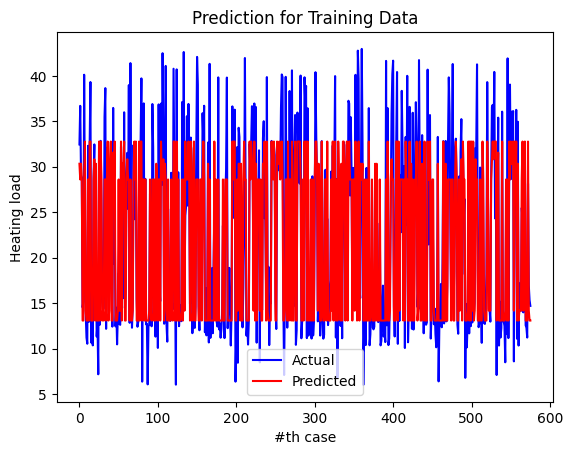

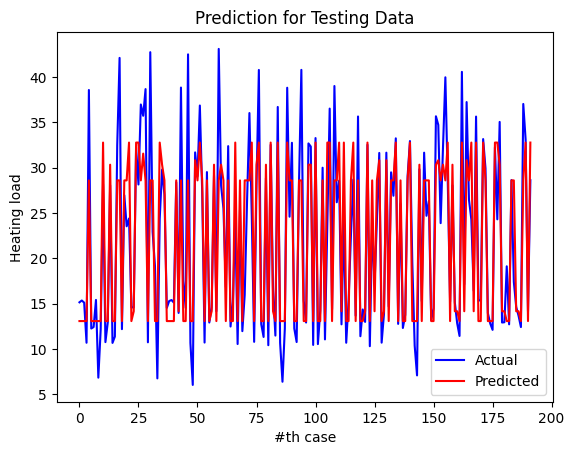

Average Training RMSE: 5.472226996629958
Average Testing RMSE: 4.562030210281221


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
f = pd.read_csv('drive/MyDrive/2024_energy_efficiency_data.csv')

def preprocess_data(filepath):
    # 1. Get the categorical features for one-hot encoding
    orientation_col = f['Orientation'].values
    glazing_area_distribution_col = f['Glazing Area Distribution'].values

    # 2. Get unique categories
    orientations = sorted(set(orientation_col))
    glazing_area_distributions = sorted(set(glazing_area_distribution_col))

    # 3. Create a new DataFrame to store the results of one-hot encoding
    orientation_dummies = np.zeros((len(f), len(orientations)))
    glazing_area_dummies = np.zeros((len(f), len(glazing_area_distributions)))

    # 4. Perform one-hot encoding on the 'Orientation' column
    for i in range(len(f)):
        current_orientation = orientation_col[i]
        orient_index = orientations.index(current_orientation)
        orientation_dummies[i, orient_index] = 1

    # 5. Perform one-hot encoding on the 'Glazing Area Distribution' column
    for i in range(len(f)):
        current_distribution = glazing_area_distribution_col[i]
        glazing_index = glazing_area_distributions.index(current_distribution)
        glazing_area_dummies[i, glazing_index] = 1

    # 6. Convert the one-hot encoded results to DataFrame
    orientation_dummies_df = pd.DataFrame(orientation_dummies, columns=orientations)
    glazing_area_dummies_df = pd.DataFrame(glazing_area_dummies, columns=glazing_area_distributions)

    # 7. Merge the one-hot encoded DataFrame with the original data
    f_encoded = pd.concat([f, orientation_dummies_df, glazing_area_dummies_df], axis=1)

    # 8. Drop the original categorical columns
    f_encoded = f_encoded.drop(['Orientation', 'Glazing Area Distribution'], axis=1)

    # Shuffle the original order
    shuffled = f_encoded.sample(frac=1, random_state=0).reset_index(drop=True)
    trainsize = int(0.75 * len(shuffled))
    trainset = shuffled[:trainsize]
    testset = shuffled[trainsize:]

    # Separate features (X) and target (y) sets
    X_train = trainset.drop(columns=['Heating Load']).values
    y_train = trainset['Heating Load'].values
    X_test = testset.drop(columns=['Heating Load']).values
    y_test = testset['Heating Load'].values
    return X_train, y_train, X_test, y_test

layers = 3

def activation_func(x, actfunc, diff=False):
    if actfunc == 'sigmoid':
        if diff:
            return np.exp(-x) / ((1 + np.exp(-x)) ** 2)
        else:
            return 1 / (1 + np.exp(-x))
    if actfunc == 'relu':
        if diff:
            return np.where(x > 0, 1, 0)
        else:
            return np.maximum(0, x)
    if actfunc == 'tanh':
        if diff:
            return 1 - np.tanh(x) ** 2
        else:
            return np.tanh(x)

class NN:
    def __init__(self, layer_dim, learning_rate, batchsize, epochs, activation='tanh'):
        self.layers = len(layer_dim)
        self.layer_dim = layer_dim
        self.learning_rate = learning_rate
        self.batchsize = batchsize
        self.epochs = epochs
        self.activation = activation  # Store the activation function choice
        self.weights, self.biases = self.initialize_parameters()

    def initialize_parameters(self):
        weights = []
        biases = []
        for i in range(self.layers):
            weights.append(np.random.randn(self.layer_dim[i][0], self.layer_dim[i][1]) * 0.01)
            biases.append(np.random.rand(self.layer_dim[i][1]))
        return weights, biases

    def rms_sum(self, Y, h):
        return np.sum(np.square(Y - h))

    def rmse(self, Y, h):
        return math.sqrt(np.mean(np.square(Y - h)))

    def forward(self, X):
        b_act = []
        a_act = [X]
        for i in range(self.layers):
            btemp = np.dot(a_act[i], self.weights[i]) + self.biases[i]
            b_act.append(btemp)
            if i < self.layers - 1:
                btemp = activation_func(btemp, self.activation)
            a_act.append(btemp)
        return b_act, a_act

    def back_prop(self, b_act, a_act, y):
        w_grad = []
        delta = a_act[-1] - y.reshape(-1, 1)
        for i in range(self.layers):
            w_grad.insert(0, np.dot(a_act[-2-i].T, delta))
            delta = np.dot(delta, self.weights[-1-i].T)
        b_grad = [np.mean(2 * (a_act[-1] - y), axis=0)]
        b_grad.insert(0, np.mean(activation_func(a_act[2], actfunc=self.activation, diff=True), axis=0))
        b_grad.insert(0, np.mean(activation_func(a_act[1], actfunc=self.activation, diff=True), axis=0))
        return w_grad, b_grad

    def update(self, w_grad, b_grad, batchsize):
        for i in range(self.layers):
            self.weights[i] -= self.learning_rate * w_grad[i] / batchsize
            self.biases[i] -= self.learning_rate * np.mean(b_grad[i], axis=0) / batchsize

    def train(self, X_train, y_train, X_test, y_test):
        input_no = X_train.shape[0]
        batch_no = input_no // self.batchsize
        last_batch = input_no % self.batchsize
        last_batch_on = last_batch > 0

        trainloss = []
        testloss = []  # 新增testloss列表來記錄每個epoch的測試損失
        train_perf = []
        test_perf = []

        for epoch in range(self.epochs):
            epoch_train_loss = 0
            y_train_pred = np.zeros_like(y_train)

            for k in range(batch_no):
                X_batch = X_train[k * self.batchsize: (k + 1) * self.batchsize]
                y_batch = y_train[k * self.batchsize: (k + 1) * self.batchsize]

                b_act, a_act = self.forward(X_batch)
                train_loss = self.rms_sum(y_batch, a_act[-1])
                epoch_train_loss += train_loss

                y_train_pred[k * self.batchsize: (k + 1) * self.batchsize] = a_act[-1].reshape(-1)

                w_grad, b_grad = self.back_prop(b_act, a_act, y_batch)
                self.update(w_grad, b_grad, self.batchsize)

            if last_batch_on:
                X_last_batch = X_train[batch_no * self.batchsize:]
                y_last_batch = y_train[batch_no * self.batchsize:]

                b_act, a_act = self.forward(X_last_batch)
                train_loss = self.rms_sum(y_last_batch, a_act[-1])
                epoch_train_loss += train_loss

                y_train_pred[batch_no * self.batchsize:] = a_act[-1].reshape(-1)

                w_grad, b_grad = self.back_prop(b_act, a_act, y_last_batch)
                self.update(w_grad, b_grad, last_batch)

            trainloss.append(epoch_train_loss / (batch_no + (1 if last_batch_on else 0)))

            # 每個epoch都計算測試損失
            b_act_t, a_act_t = self.forward(X_test)
            test_loss = self.rms_sum(y_test, a_act_t[-1])

            if epoch % 100 == 0:
                print(f"Epoch {epoch}/{self.epochs} - Training Loss: {trainloss[-1]}")

        # 在訓練結束後計算 RMSE 並顯示
        train_rmse = self.rmse(y_train, y_train_pred)
        test_rmse = self.rmse(y_test, a_act_t[-1].reshape(-1))

        print(f"Final Training Loss: {trainloss[-1]}")
        print(f"Train RMSE: {train_rmse}")
        print(f"Test RMSE: {test_rmse}")

        return trainloss, train_rmse, test_rmse

    def predict(self, X):
        _, a_act = self.forward(X)
        return a_act[-1]

def plot_results(epochs, Lossing_train,  train_performance, test_performance, result1, result2, Y_train, Y_test):
    epoch_list = [i for i in range(epochs)]
    plt.figure(1)
    plt.plot(epoch_list, Lossing_train, label="Training Loss")
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Learning Curve')

    length = len(result1)
    train_data = [i for i in range(length)]
    plt.figure(2)
    plt.plot(train_data, Y_train, label="Actual", color='blue')
    plt.plot(train_data, result1, label="Predicted", color='red')
    plt.legend()
    plt.xlabel('#th case')
    plt.ylabel('Heating load')
    plt.title('Prediction for Training Data')

    length2 = len(result2)
    test_data = [i for i in range(length2)]
    plt.figure(3)
    plt.plot(test_data, Y_test, label="Actual", color='blue')
    plt.plot(test_data, result2, label="Predicted", color='red')
    plt.legend()
    plt.xlabel('#th case')
    plt.ylabel('Heating load')
    plt.title('Prediction for Testing Data')
    plt.show()

# Define hyperparameters
def main():
    X_train, y_train, X_test, y_test = preprocess_data(f)
    print(X_train.shape)
    layer_dim = [[X_train.shape[1], 10], [10, 16], [16, 1]]
    learning_rate = 0.001
    epochs = 1500

    # Create a neural network object (Choose tanh or relu)
    nn = NN(layer_dim, learning_rate, batchsize=32, epochs=epochs, activation='sigmoid')  # You can change to 'relu'

    # Train the neural network
    trainloss, train_perf, test_perf = nn.train(X_train, y_train, X_test, y_test)

    # Test predictions
    predictions = nn.predict(X_test)

    # Plot results
    plot_results(epochs, trainloss, train_perf, test_perf, nn.predict(X_train), predictions, y_train, y_test)
    avg_train_rmse = np.mean(train_perf)
    avg_test_rmse = np.mean(test_perf)

    print(f"Average Training RMSE: {avg_train_rmse}")
    print(f"Average Testing RMSE: {avg_test_rmse}")


if __name__ == '__main__':
    main()


Training model with 5 hidden neurons...
Epoch 20, Loss: 0.6910176171507485, Train Accuracy: 0.55, Test Accuracy: 1.00


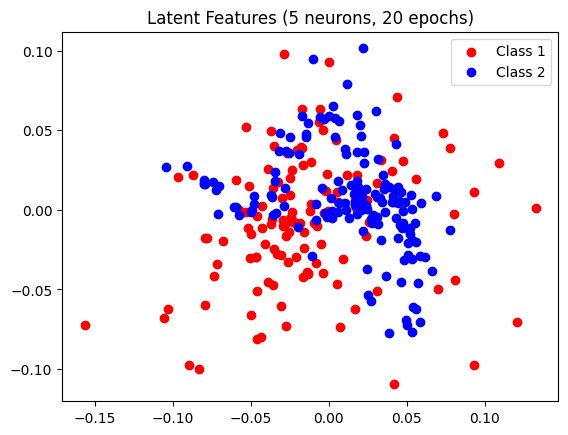

Epoch 500, Loss: 0.3604867624549272, Train Accuracy: 0.86, Test Accuracy: 0.97


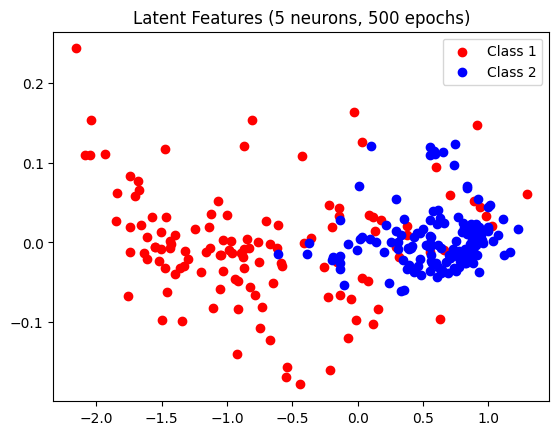

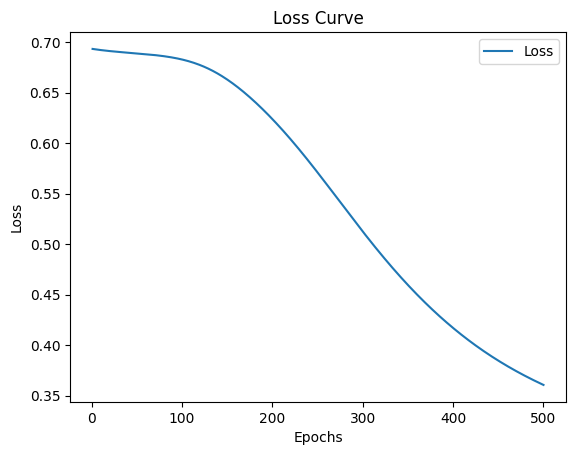

34
Training model with 10 hidden neurons...
Epoch 20, Loss: 0.6909988850792574, Train Accuracy: 0.55, Test Accuracy: 1.00


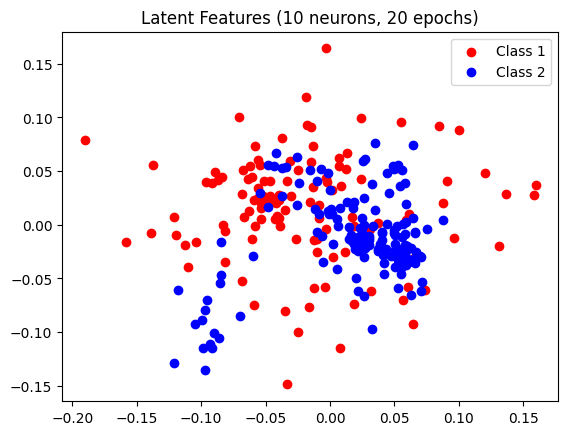

Epoch 500, Loss: 0.35325569302865356, Train Accuracy: 0.86, Test Accuracy: 0.97


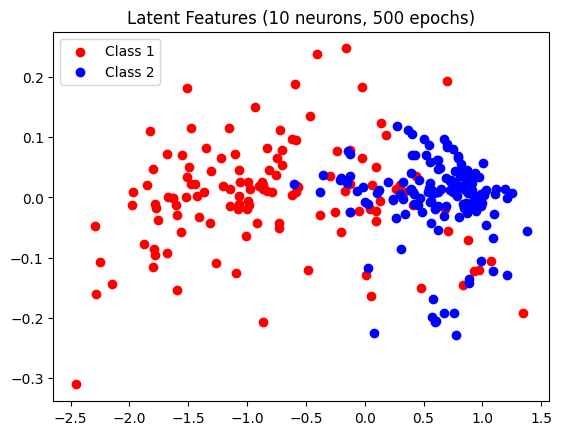

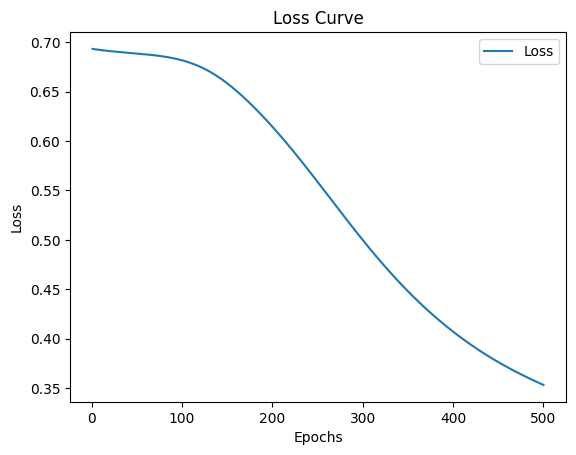

34
Training model with 15 hidden neurons...
Epoch 20, Loss: 0.690627256171556, Train Accuracy: 0.55, Test Accuracy: 1.00


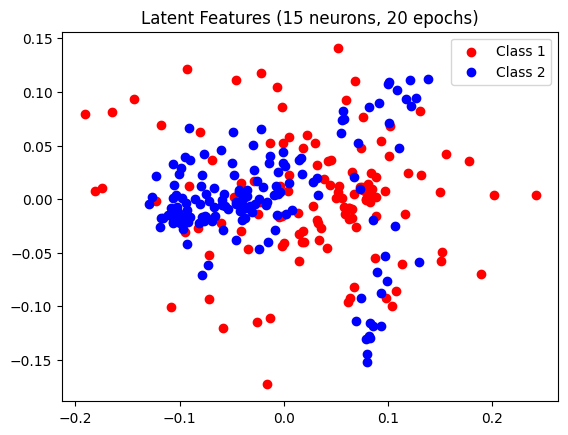

Epoch 500, Loss: 0.3390165163330994, Train Accuracy: 0.86, Test Accuracy: 0.97


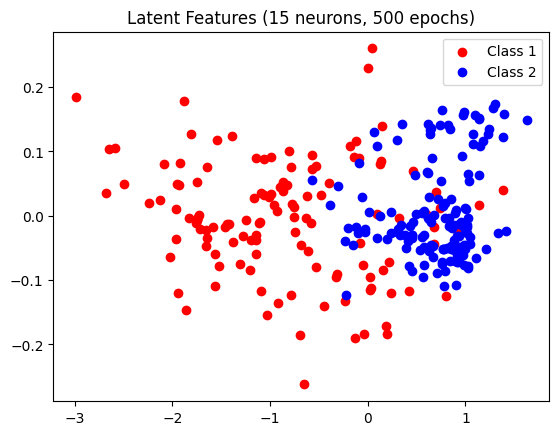

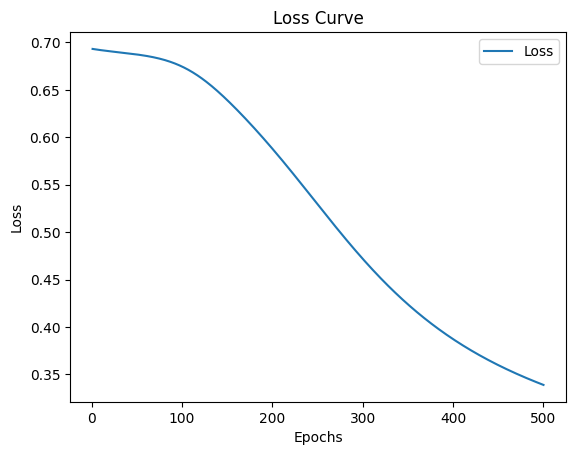

34
   Hidden Neurons  Epoch      Loss  Training Error Rate  Test Error Rate
0               5     20  0.691018             0.450000         0.000000
1               5    500  0.360487             0.135714         0.028169
2              10     20  0.690999             0.450000         0.000000
3              10    500  0.353256             0.139286         0.028169
4              15     20  0.690627             0.450000         0.000000
5              15    500  0.339017             0.142857         0.028169


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd

# 初始化參數
def initialize_parameters(n_x, n_h, n_y):
    np.random.seed(1)
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))

    return W1, b1, W2, b2

# 前向傳播
def forward_propagation(X, W1, b1, W2, b2):
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = 1 / (1 + np.exp(-Z2))  # Sigmoid function

    return A1, A2

# 反向傳播
def backward_propagation(X, Y, A1, A2, W2):
    m = X.shape[1]

    dZ2 = A2 - Y
    dW2 = (1/m) * np.dot(dZ2, A1.T)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)

    dZ1 = np.dot(W2.T, dZ2) * (1 - np.power(A1, 2))
    dW1 = (1/m) * np.dot(dZ1, X.T)
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)

    return dW1, db1, dW2, db2

# 損失函數
def compute_loss(A2, Y):
    m = Y.shape[1]
    logprobs = Y * np.log(A2) + (1 - Y) * np.log(1 - A2)
    loss = -np.sum(logprobs) / m
    return loss

# 計算準確率
def compute_accuracy(A2, Y):
    predictions = (A2 > 0.5).astype(int)  # 設定閾值為0.5
    accuracy = np.mean(predictions == Y)  # 計算準確率
    return accuracy

# 訓練模型
def model(X, Y, n_h, epoch, W1, b1, W2, b2, learning_rate=0.05):
    for i in range(epoch):
        # 前向傳播
        A1, A2 = forward_propagation(X, W1, b1, W2, b2)

        # 計算損失
        loss = compute_loss(A2, Y)

        # 反向傳播
        dW1, db1, dW2, db2 = backward_propagation(X, Y, A1, A2, W2)

        # 更新參數
        W1 -= learning_rate * dW1
        b1 -= learning_rate * db1
        W2 -= learning_rate * dW2
        b2 -= learning_rate * db2

    return W1, b1, W2, b2, loss, A2

# 繪製特徵分佈
def plot_latent_features(A1, Y, title):
    pca = PCA(n_components=2)
    latent_features = pca.fit_transform(A1.T)

    plt.figure()
    plt.scatter(latent_features[Y.flatten() == 0, 0], latent_features[Y.flatten() == 0, 1], color='red', label='Class 1')
    plt.scatter(latent_features[Y.flatten() == 1, 0], latent_features[Y.flatten() == 1, 1], color='blue', label='Class 2')
    plt.title(title)
    plt.legend()
    plt.show()

# 繪製loss曲線
def plot_loss_curve(losses):
    plt.figure()
    plt.plot(range(1, len(losses) + 1), losses, label='Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.show()

# 主程式
if __name__ == "__main__":
    # 載入資料集
    data = np.loadtxt('drive/MyDrive/2024_ionosphere_data.csv', delimiter=',', dtype=str)

    X = data[:, :-1].astype(float).T  # 特徵 (34 features)
    Y = (data[:, -1] == 'g').astype(int).reshape(1, -1)  # 類標籤 (g 為 1, b 為 0)

    # 訓練集和測試集分割
    m = X.shape[1]
    m_train = int(0.8 * m)
    X_train, X_test = X[:, :m_train], X[:, m_train:]
    Y_train, Y_test = Y[:, :m_train], Y[:, m_train:]

    # 設定隱藏層節點數量
    hidden_layer_sizes = [5, 10, 15]  # 多個隱藏層節點數
    results = []
    # 訓練模型，並每50個epoch畫一次圖，並顯示loss與準確率
    for n_h in hidden_layer_sizes:
        print(f"Training model with {n_h} hidden neurons...")

        # 初始化權重和偏置
        W1, b1, W2, b2 = initialize_parameters(X_train.shape[0], n_h, 1)

        # 訓練迴圈
        losses = []
        for epoch in range(1, 501):  # 訓練400次
            # 前向與反向傳播來更新參數
            W1, b1, W2, b2, loss, A2_train = model(X_train, Y_train, n_h=n_h, epoch=1, W1=W1, b1=b1, W2=W2, b2=b2)
            losses.append(loss)  # 記錄每次的loss值

            # 每50個epoch繪製一次隱含層特徵分佈，並顯示loss和準確率
            if epoch == 20 or epoch == 500:
                train_accuracy = compute_accuracy(A2_train, Y_train)

                # 前向傳播獲得測試集的預測
                _, A2_test = forward_propagation(X_test, W1, b1, W2, b2)
                test_accuracy = compute_accuracy(A2_test, Y_test)

                print(f"Epoch {epoch}, Loss: {loss}, Train Accuracy: {train_accuracy:.2f}, Test Accuracy: {test_accuracy:.2f}")

                # 使用前向傳播獲得隱含層特徵
                A1_train, _ = forward_propagation(X_train, W1, b1, W2, b2)
                results.append([n_h, epoch, loss, 1 - train_accuracy, 1 - test_accuracy])

                # 繪製隱含層特徵的2D分佈
                plot_latent_features(A1_train, Y_train, f'Latent Features ({n_h} neurons, {epoch} epochs)')

        # 繪製loss曲線
        plot_loss_curve(losses)
        print(X_train.shape[0])
    df_results = pd.DataFrame(results, columns=["Hidden Neurons", "Epoch", "Loss", "Training Error Rate", "Test Error Rate"])
    print(df_results)


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.feature_selection import SelectKBest, f_classif

f = pd.read_csv('drive/MyDrive/2024_energy_efficiency_data.csv')

# Already existing functions like preprocess_data, activation_func, NN, etc.
def preprocess_data(f, k):
    # 1. Get the categorical features for one-hot encoding
    orientation_col = f['Orientation'].values
    glazing_area_distribution_col = f['Glazing Area Distribution'].values

    # 2. Get unique categories
    orientations = sorted(set(orientation_col))
    glazing_area_distributions = sorted(set(glazing_area_distribution_col))

    # 3. Create a new DataFrame to store the results of one-hot encoding
    orientation_dummies = np.zeros((len(f), len(orientations)))
    glazing_area_dummies = np.zeros((len(f), len(glazing_area_distributions)))

    # 4. Perform one-hot encoding on the 'Orientation' column
    for i in range(len(f)):
        current_orientation = orientation_col[i]
        orient_index = orientations.index(current_orientation)
        orientation_dummies[i, orient_index] = 1

    # 5. Perform one-hot encoding on the 'Glazing Area Distribution' column
    for i in range(len(f)):
        current_distribution = glazing_area_distribution_col[i]
        glazing_index = glazing_area_distributions.index(current_distribution)
        glazing_area_dummies[i, glazing_index] = 1

    # 6. Convert the one-hot encoded results to DataFrame, and name columns to make them identifiable
    orientation_dummies_df = pd.DataFrame(orientation_dummies, columns=[f"Orientation_{o}" for o in orientations])
    glazing_area_dummies_df = pd.DataFrame(glazing_area_dummies, columns=[f"Glazing_Area_Distribution_{g}" for g in glazing_area_distributions])

    # 7. Merge the one-hot encoded DataFrame with the original data
    f_encoded = pd.concat([f, orientation_dummies_df, glazing_area_dummies_df], axis=1)

    # 8. Drop the original categorical columns
    f_encoded = f_encoded.drop(['Orientation', 'Glazing Area Distribution'], axis=1)

    # 9. Shuffle the data and split into training and testing sets
    shuffled = f_encoded.sample(frac=1, random_state=0).reset_index(drop=True)
    trainsize = int(0.75 * len(shuffled))
    trainset = shuffled[:trainsize]
    testset = shuffled[trainsize:]

    # 10. Separate features (X) and target (y) sets
    X_train = trainset.drop(columns=['Heating Load']).values
    y_train = trainset['Heating Load'].values
    X_test = testset.drop(columns=['Heating Load']).values
    y_test = testset['Heating Load'].values

    # Get feature names, now including detailed one-hot encoded feature names
    feature_names = f_encoded.drop(columns=['Heating Load']).columns.values

    # Apply Fisher Score feature selection 並獲取選擇的特徵名稱
    X_train_selected, selector, selected_feature_names = fisher_score_selection(X_train, y_train, k, feature_names)

    # Transform test set based on selected features
    X_test_selected = selector.transform(X_test)

    return X_train_selected, y_train, X_test_selected, y_test, selected_feature_names


def main():
    k_values = [8, 10, 12, 14]  # Use different k-best values
    results = []

    for k in k_values:
        print(f"\nTraining with top {k} Fisher Score features:")

        # Preprocess the data with the top k features
        X_train, y_train, X_test, y_test, selected_feature_names = preprocess_data(f, k)
        print(f"Selected features for k={k}: {selected_feature_names}")  # 輸出被選擇的特徵
        print(X_train.shape)
        # Define layer dimensions dynamically based on input size
        layer_dim = [[X_train.shape[1], 10], [10, 16], [16, 1]]

        # Set the same learning rate and epochs for each run
        learning_rate = 0.001
        epochs = 1500

        # Create a neural network object (Choose tanh or relu)
        nn = NN(layer_dim, learning_rate, batchsize=32, epochs=epochs, activation='sigmoid')

        # Train the neural network
        trainloss, train_perf, test_perf = nn.train(X_train, y_train, X_test, y_test)

        # Store results
        avg_train_rmse = np.mean(train_perf)
        avg_test_rmse = np.mean(test_perf)
        results.append((k, avg_train_rmse, avg_test_rmse))
        # Plot results

    # Summary of all results
    print("\nSummary of results:")
    for result in results:
        k, train_rmse, test_rmse = result
        print(f"Top {k} features - Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")


if __name__ == '__main__':
    main()



Training with top 8 Fisher Score features:
Selected 8 features: ['# Relative Compactness' 'Surface Area' 'Wall Area' 'Roof Area'
 'Overall Height' 'Glazing Area' 'Cooling Load'
 'Glazing_Area_Distribution_0.0']
Selected features for k=8: ['# Relative Compactness' 'Surface Area' 'Wall Area' 'Roof Area'
 'Overall Height' 'Glazing Area' 'Cooling Load'
 'Glazing_Area_Distribution_0.0']
(576, 8)
Epoch 0/1500 - Training Loss: 557842.096645262


/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
<ipython-input-6-311d647cf1f7>:62: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 100/1500 - Training Loss: 124937.09328128405
Epoch 200/1500 - Training Loss: 171609.60109216804
Epoch 300/1500 - Training Loss: 162588.71246571644
Epoch 400/1500 - Training Loss: 174348.6468345915
Epoch 500/1500 - Training Loss: 176817.7404806625
Epoch 600/1500 - Training Loss: 178306.917081357
Epoch 700/1500 - Training Loss: 178532.9469949406
Epoch 800/1500 - Training Loss: 178350.83494775285
Epoch 900/1500 - Training Loss: 176728.33322734918
Epoch 1000/1500 - Training Loss: 176150.76943847726
Epoch 1100/1500 - Training Loss: 176618.05367550222
Epoch 1200/1500 - Training Loss: 176109.3686106311
Epoch 1300/1500 - Training Loss: 175334.89823280738
Epoch 1400/1500 - Training Loss: 174667.92190119976
Final Training Loss: 174945.59457874845
Train RMSE: 5.418219634431205
Test RMSE: 4.556524261008547

Training with top 10 Fisher Score features:
Selected 10 features: ['# Relative Compactness' 'Surface Area' 'Wall Area' 'Roof Area'
 'Overall Height' 'Glazing Area' 'Cooling Load' 'Orienta

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
<ipython-input-6-311d647cf1f7>:62: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 100/1500 - Training Loss: 105730.03596789495
Epoch 200/1500 - Training Loss: 176931.3295364573
Epoch 300/1500 - Training Loss: 170121.62612133723
Epoch 400/1500 - Training Loss: 176329.07467007852
Epoch 500/1500 - Training Loss: 179489.55265561613
Epoch 600/1500 - Training Loss: 180768.7194787467
Epoch 700/1500 - Training Loss: 181931.9124237661
Epoch 800/1500 - Training Loss: 180695.4218391101
Epoch 900/1500 - Training Loss: 180612.89107779096
Epoch 1000/1500 - Training Loss: 180708.0592612764
Epoch 1100/1500 - Training Loss: 181884.72356437438
Epoch 1200/1500 - Training Loss: 179747.5636709185
Epoch 1300/1500 - Training Loss: 179637.76242624648
Epoch 1400/1500 - Training Loss: 178178.79735434888
Final Training Loss: 178100.15824401597
Train RMSE: 5.185412113269928
Test RMSE: 4.3931586695133875

Training with top 12 Fisher Score features:
Selected 12 features: ['# Relative Compactness' 'Surface Area' 'Wall Area' 'Roof Area'
 'Overall Height' 'Glazing Area' 'Cooling Load' 'Orient

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
<ipython-input-6-311d647cf1f7>:62: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 100/1500 - Training Loss: 115592.60409737626
Epoch 200/1500 - Training Loss: 174558.45127888292
Epoch 300/1500 - Training Loss: 167183.85242689506
Epoch 400/1500 - Training Loss: 175200.45206262922
Epoch 500/1500 - Training Loss: 179301.89056773653
Epoch 600/1500 - Training Loss: 180746.89917802566
Epoch 700/1500 - Training Loss: 181765.69026198745
Epoch 800/1500 - Training Loss: 181423.49055824717
Epoch 900/1500 - Training Loss: 181284.86758875972
Epoch 1000/1500 - Training Loss: 181224.61515662094
Epoch 1100/1500 - Training Loss: 180581.40576209847
Epoch 1200/1500 - Training Loss: 181242.65293388005
Epoch 1300/1500 - Training Loss: 180160.05370167433
Epoch 1400/1500 - Training Loss: 179371.96868934337
Final Training Loss: 179923.4270019139
Train RMSE: 4.933892359876544
Test RMSE: 4.295351910212209

Training with top 14 Fisher Score features:
Selected 14 features: ['# Relative Compactness' 'Surface Area' 'Wall Area' 'Roof Area'
 'Overall Height' 'Glazing Area' 'Cooling Load' 'Or

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
<ipython-input-6-311d647cf1f7>:62: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 100/1500 - Training Loss: 112441.73999381384
Epoch 200/1500 - Training Loss: 174830.9180592739
Epoch 300/1500 - Training Loss: 167810.4169549358
Epoch 400/1500 - Training Loss: 175608.9362623686
Epoch 500/1500 - Training Loss: 180276.57338150183
Epoch 600/1500 - Training Loss: 180899.45506634915
Epoch 700/1500 - Training Loss: 180928.24505147737
Epoch 800/1500 - Training Loss: 180822.62062803187
Epoch 900/1500 - Training Loss: 180691.86426846305
Epoch 1000/1500 - Training Loss: 180769.819213814
Epoch 1100/1500 - Training Loss: 180334.86468437797
Epoch 1200/1500 - Training Loss: 180406.47002195788
Epoch 1300/1500 - Training Loss: 180481.27242265188
Epoch 1400/1500 - Training Loss: 180967.14744352576
Final Training Loss: 180689.76044509228
Train RMSE: 4.883494396637967
Test RMSE: 4.252000015541435

Summary of results:
Top 8 features - Train RMSE: 5.418219634431205, Test RMSE: 4.556524261008547
Top 10 features - Train RMSE: 5.185412113269928, Test RMSE: 4.3931586695133875
Top 12 fea